## Семинар 2 "Распознавание рукописных цифр"

ФИО: Ломоносов Дмитрий Сергеевич 

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, Relu, Elu, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    print(X.shape)
    print(y)
    break

(32, 784)
[3 4 3 0 1 1 8 7 1 1 9 4 4 4 1 3 9 3 6 8 4 7 2 3 3 1 5 1 7 0 8 7]


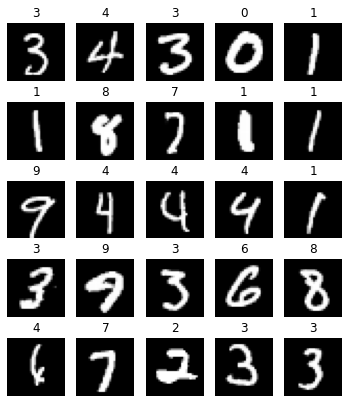

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
error_logs = {0.001: [], 0.005: [], 0.01: []}

for learning_rate in error_logs:
    nn = NeuralNetwork([Linear(784, 100), Sigmoid(), Linear(100,100), Sigmoid(), Linear(100, 10)], NLLLoss())
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        nn.train(X, y, epoch=1, learning_rate=learning_rate)
        error_logs[learning_rate] += [np.mean(nn.log_error)]


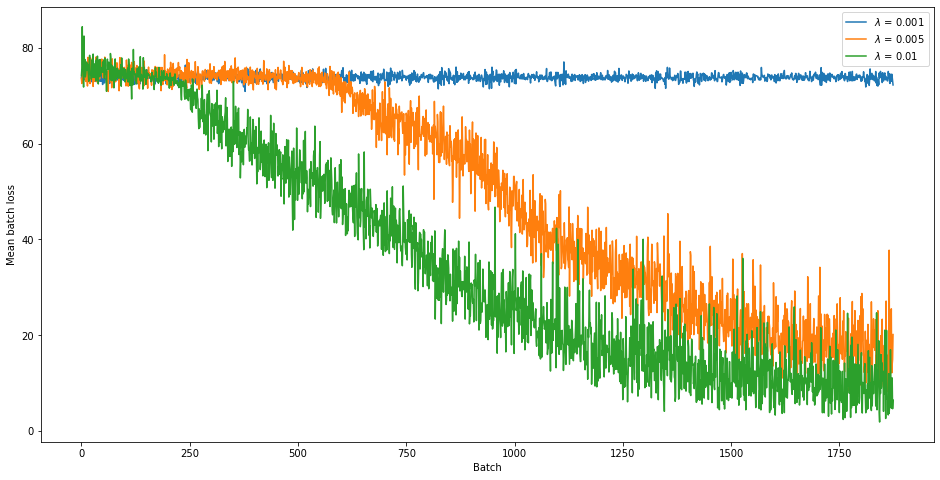

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Batch')
plt.ylabel('Mean batch loss')
for learning_rate in error_logs:
    ax.plot(error_logs[learning_rate], label=f'$\lambda$ = {learning_rate}')
ax.legend()
ax.plot();

0.01 действительно выглядит лучше своих конкурентов. Посмотрим как уменьшается лосс на тесте при $\lambda = 0.01$

In [7]:
Xs = []
ys = []
# test_loader.batch_size = 1
for X, y in test_loader:
    X = X.view(-1, X.shape[0])
    X = X.numpy().flatten() ### Converts torch.Tensor to numpy array
    y = y.numpy()
#     print(X.shape)
    Xs.append(X)
    ys.append(y)
X_test = np.array(Xs)
y_test = np.array(ys).flatten()

In [8]:
print(X_test.shape)
print(y_test.shape)

(10000, 784)
(10000,)


In [9]:
from random import sample 
test_loss = []
nn = NeuralNetwork([Linear(784, 100), Sigmoid(), Linear(100,100), Sigmoid(), Linear(100, 10)], NLLLoss())
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    nn.train(X, y, epoch=1, learning_rate=0.01)
    indexes = np.random.choice(X_test.shape[0], 32, replace=False)
    res = nn.forward(X_test[indexes])
    test_loss.append(nn.loss.forward(res, y_test[indexes]))

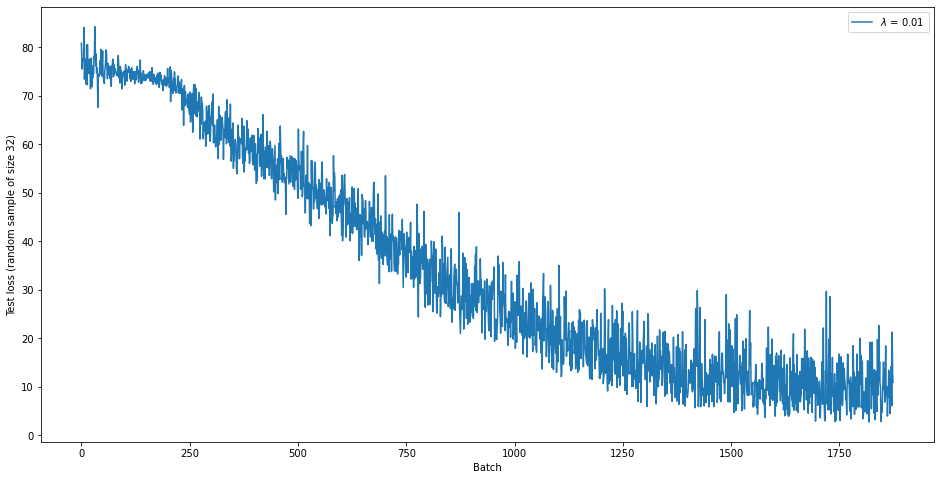

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Batch')
plt.ylabel('Test loss (random sample of size 32)')
ax.plot(test_loss, label=f'$\lambda$ = {0.01}')
ax.legend()
ax.plot();

In [11]:
print(f"Minimal batch error on train: {np.min(error_logs[0.01]) / 32}")
print(f"Minimal test error: {np.min(test_loss) / 32}")

Minimal batch error on train: 0.058911133003075794
Minimal test error: 0.08659197786930567


### Посмотрим на цифорки в которых мы ошибаемся

accuracy: 0.9147


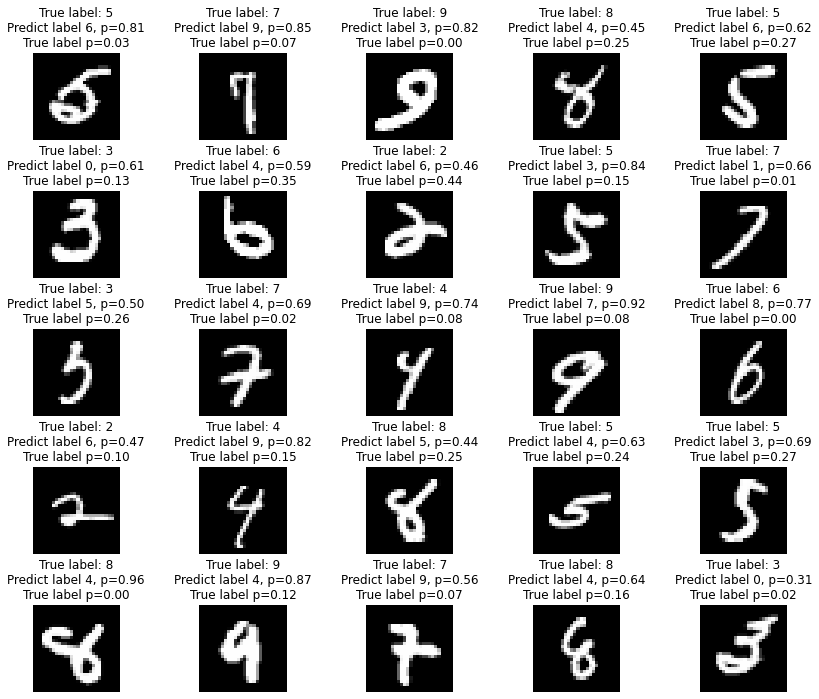

In [12]:
y_pred = nn.forward(X_test)

y_proba = np.exp(y_pred) / np.exp(y_pred).sum(axis=1)[:, None]

missclass = np.where(np.argmax(y_proba, axis=1) != y_test)[0]
print(f"accuracy: {1 - len(missclass) / len(y_test)}")
fig, axes = plt.subplots(5, 5, figsize=(12, 10))
axes = axes.flatten()
plt.tight_layout(pad=3)
for k, i in enumerate(missclass[:25]):
    axes[k].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    axes[k].set_title('True label: {}\n'.format(y_test[i]) + \
              'Predict label {}, p={:.2f}\n'.format(np.argmax(y_proba[i]), np.max(y_proba[i])) + \
              'True label p={:.2f}'.format(y_proba[i, y_test[i]]))
    axes[k].axis('off')

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

### Relu

In [13]:
test_loss = []
nn = NeuralNetwork([Linear(784, 100), Relu(), Linear(100,100), Relu(), Linear(100, 10)], NLLLoss())
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    nn.train(X, y, epoch=1, learning_rate=0.01, save_prev_log=True)
    indexes = np.random.choice(X_test.shape[0], 32, replace=False)
    res = nn.forward(X_test[indexes])
    test_loss.append(nn.loss.forward(res, y_test[indexes]))

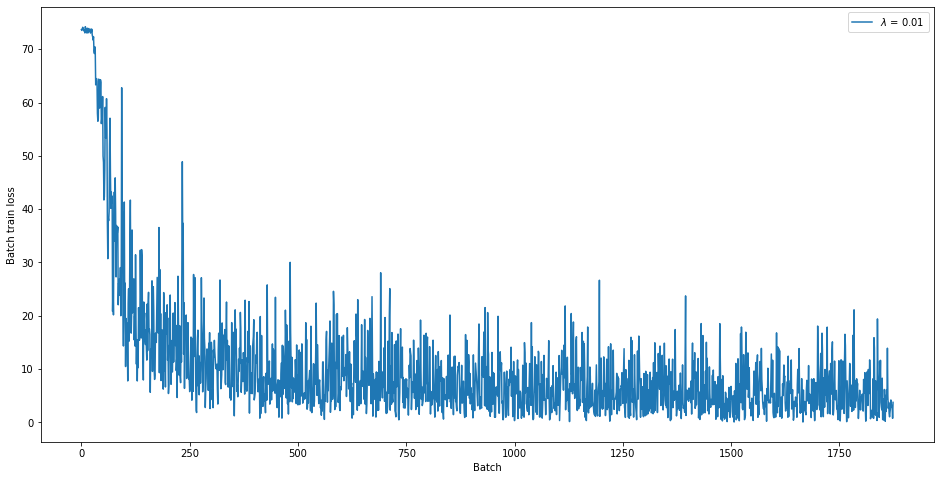

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Batch')
plt.ylabel('Batch train loss')
ax.plot(nn.log_error, label=f'$\lambda$ = {0.01}')
ax.legend()
ax.plot();

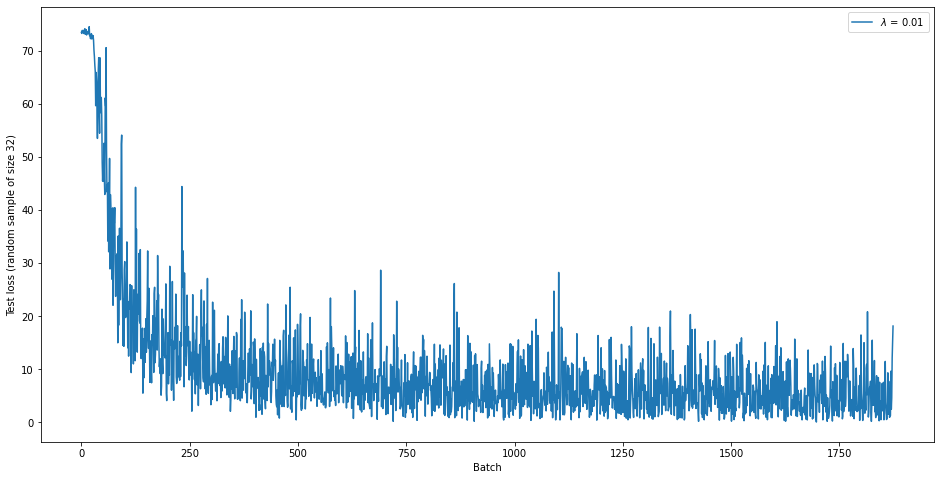

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Batch')
plt.ylabel('Test loss (random sample of size 32)')
ax.plot(test_loss, label=f'$\lambda$ = {0.01}')
ax.legend()
ax.plot();

accuracy: 0.9625


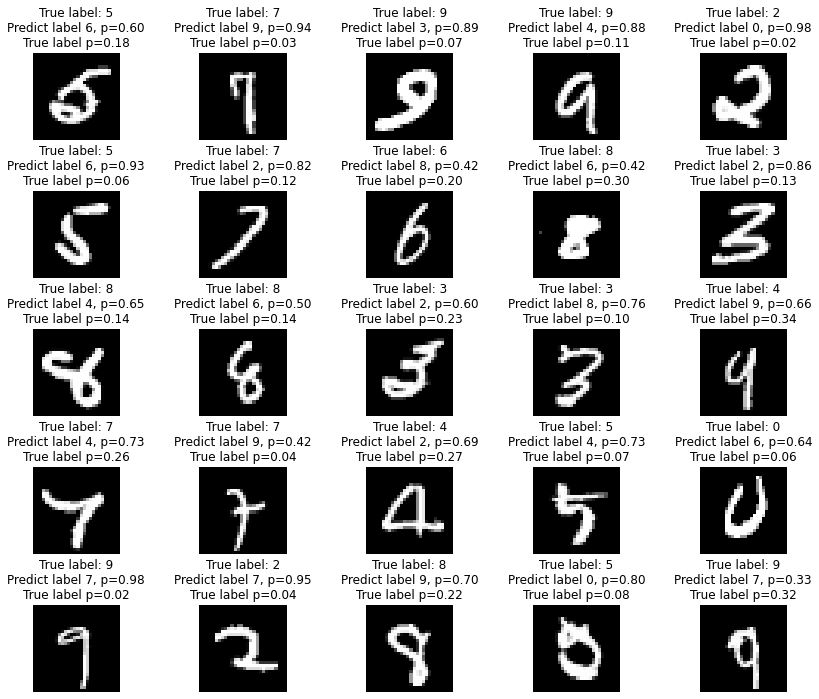

In [16]:
y_pred = nn.forward(X_test)
y_proba = np.exp(y_pred) / np.exp(y_pred).sum(axis=1)[:, None]
missclass = np.where(np.argmax(y_proba, axis=1) != y_test)[0]
print(f"accuracy: {1 - len(missclass) / len(y_test)}")
fig, axes = plt.subplots(5, 5, figsize=(12, 10))
axes = axes.flatten()
plt.tight_layout(pad=3)
for k, i in enumerate(missclass[:25]):
    axes[k].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    axes[k].set_title('True label: {}\n'.format(y_test[i]) + \
              'Predict label {}, p={:.2f}\n'.format(np.argmax(y_proba[i]), np.max(y_proba[i])) + \
              'True label p={:.2f}'.format(y_proba[i, y_test[i]]))
    axes[k].axis('off')

### Elu

In [17]:
test_loss = []
nn = NeuralNetwork([Linear(784, 100), Elu(), Linear(100,100), Elu(), Linear(100, 10)], NLLLoss())
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    nn.train(X, y, epoch=1, learning_rate=0.01, save_prev_log=True)
    indexes = np.random.choice(X_test.shape[0], 32, replace=False)
    res = nn.forward(X_test[indexes])
    test_loss.append(nn.loss.forward(res, y_test[indexes]))

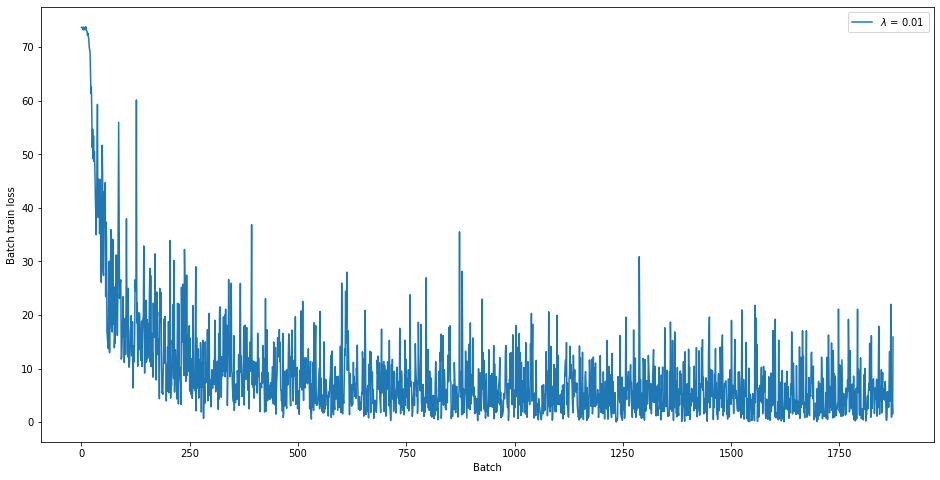

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Batch')
plt.ylabel('Batch train loss')
ax.plot(nn.log_error, label=f'$\lambda$ = {0.01}')
ax.legend()
ax.plot();

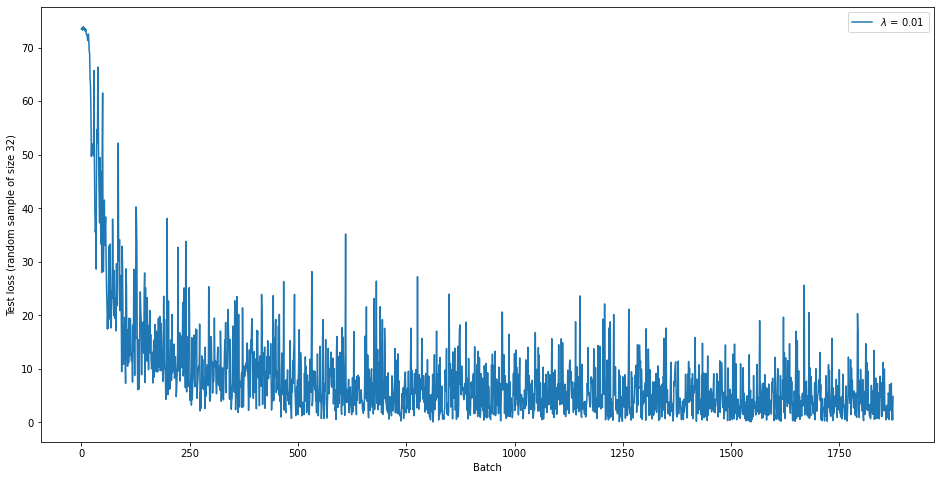

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Batch')
plt.ylabel('Test loss (random sample of size 32)')
ax.plot(test_loss, label=f'$\lambda$ = {0.01}')
ax.legend()
ax.plot();

accuracy: 0.9319


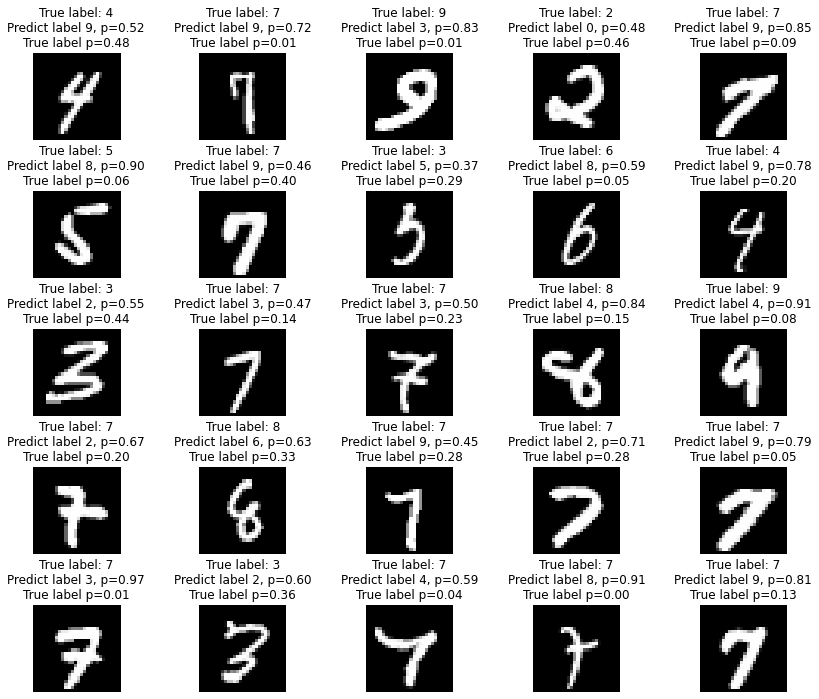

In [20]:
y_pred = nn.forward(X_test)
y_proba = np.exp(y_pred) / np.exp(y_pred).sum(axis=1)[:, None]
missclass = np.where(np.argmax(y_proba, axis=1) != y_test)[0]
print(f"accuracy: {1 - len(missclass) / len(y_test)}")
fig, axes = plt.subplots(5, 5, figsize=(12, 10))
axes = axes.flatten()
plt.tight_layout(pad=3)
for k, i in enumerate(missclass[:25]):
    axes[k].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    axes[k].set_title('True label: {}\n'.format(y_test[i]) + \
              'Predict label {}, p={:.2f}\n'.format(np.argmax(y_proba[i]), np.max(y_proba[i])) + \
              'True label p={:.2f}'.format(y_proba[i, y_test[i]]))
    axes[k].axis('off')

### Tanh

In [21]:
test_loss = []
nn = NeuralNetwork([Linear(784, 100), Tanh(), Linear(100,100), Tanh(), Linear(100, 10)], NLLLoss())
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    nn.train(X, y, epoch=1, learning_rate=0.01, save_prev_log=True)
    indexes = np.random.choice(X_test.shape[0], 32, replace=False)
    res = nn.forward(X_test[indexes])
    test_loss.append(nn.loss.forward(res, y_test[indexes]))

NameError: name 'Tanh' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Batch')
plt.ylabel('Batch train loss')
ax.plot(nn.log_error, label=f'$\lambda$ = {0.01}')
ax.legend()
ax.plot();

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Batch')
plt.ylabel('Test loss (random sample of size 32)')
ax.plot(test_loss, label=f'$\lambda$ = {0.01}')
ax.legend()
ax.plot();

In [ ]:
y_pred = nn.forward(X_test)
y_proba = np.exp(y_pred) / np.exp(y_pred).sum(axis=1)[:, None]
missclass = np.where(np.argmax(y_proba, axis=1) != y_test)[0]
print(f"accuracy: {1 - len(missclass) / len(y_test)}")
fig, axes = plt.subplots(5, 5, figsize=(12, 10))
axes = axes.flatten()
plt.tight_layout(pad=3)
for k, i in enumerate(missclass[:25]):
    axes[k].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    axes[k].set_title('True label: {}\n'.format(y_test[i]) + \
              'Predict label {}, p={:.2f}\n'.format(np.argmax(y_proba[i]), np.max(y_proba[i])) + \
              'True label p={:.2f}'.format(y_proba[i, y_test[i]]))
    axes[k].axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?